In [4]:
# %% Import modules
import torch
import einops

from transformer_lens import HookedTransformer, FactoredMatrix

import matplotlib.pyplot as plt
import seaborn as sns
from load_data import get_prompts_t

In [5]:
# Global settings and variables
sns.set()
torch.set_grad_enabled(False)
device = "cpu"

IPSUM = "Lorem Ipsum is simply dummy text of the printing and typesetting industry. Lorem Ipsum has been the industry's standard dummy text ever since the 1500s, when an unknown printer took a galley of type and scrambled it to make a type specimen book. It has survived not only five centuries, but also the leap into electronic typesetting, remaining essentially unchanged. It was popularised in the 1960s with the release of Letraset sheets containing Lorem Ipsum passages, and more recently with desktop publishing software like Aldus PageMaker including versions of Lorem Ipsum."
# IPSUM = ""

In [6]:
#%% Setup model & load data
model = HookedTransformer.from_pretrained('gelu-4l')
model.cfg.use_attn_result = True
model.to(device)

prompts_t = get_prompts_t()

Loaded pretrained model gelu-4l into HookedTransformer
Moving model to device:  cpu
Loading 80 prompts from c4-tokenized-2b...


100%|██████████| 80/80 [00:03<00:00, 24.27it/s]


Loading 20 prompts from code-tokenized...


100%|██████████| 20/20 [00:02<00:00,  7.10it/s]


In [11]:
examples = [
    {
        "text": 4 * IPSUM + " It's in the cupboard, either on the top or the",
        "correct": " bottom",
        "incorrect": " top",
    },
    {
        "text": 5 * IPSUM + " I went to university at Michigan",
        "correct": " State",
        "incorrect": " University",
    },
    {
        "text": IPSUM + " class MyClass:\n\tdef",
        "correct": " __",
        "incorrect": " on",
    },
    {
        "text": 6 * IPSUM + "The church I go to is the Seventh-day Adventist",
        "correct": " Church",
        "incorrect": " Advent",
    }
]

In [12]:
def get_results(model, example):
    token_ids = model.to_tokens(example["text"])
    correct_token_id = model.to_single_token(example["correct"])
    incorrect_token_id = model.to_single_token(example["incorrect"])
    logit_diff_direction = (
        model.W_U[:, correct_token_id] - model.W_U[:, incorrect_token_id]
    )  # (d_model,)

    _, cache = model.run_with_cache(
        token_ids,
        names_filter=lambda name: (
            name == "blocks.0.attn.hook_result"
            or name == "blocks.2.attn.hook_result"
            or name == "blocks.2.ln1.hook_scale"
            or name == "ln_final.hook_scale"
            or name == "ln_final.hook_normalized"
        ),
    )

    # 

    L0H2 = cache["blocks.0.attn.hook_result"][:, :, 2, :]  # (batch, pos, d_model)
    L0H2_block2_ln = (L0H2 - L0H2.mean(dim=-1, keepdim=True)) / cache["blocks.2.ln1.hook_scale"]
    L2HX = einops.reduce(
        cache["blocks.2.attn.hook_result"],
        "batch pos head d_model -> batch pos d_model",
        "sum",
    )

    # Get V-composition of L0H2 to L2HX
    # Use six heads only
    L2HX_W_OV = einops.einsum(
        model.W_V[2, 2:],
        model.W_O[2, 2:],
        "head d_model_V d_head, head d_head d_model_O -> head d_model_V d_model_O"
    )

    v_comp = einops.einsum(
        L0H2_block2_ln, 
        L2HX_W_OV,
        "batch pos d_model_V, head d_model_V d_model_O -> batch pos d_model_O"
    )


    scale = cache["ln_final.hook_scale"]

    apply_ln = lambda x: (x - x.mean(dim=-1, keepdim=True)) / scale
    L0H2_ln = apply_ln(L0H2)
    L2HX_ln = apply_ln(L2HX)
    v_comp_ln = apply_ln(v_comp)

    

    return (
        L0H2_ln[0, -1, :] @ logit_diff_direction,
        L2HX_ln[0, -1, :] @ logit_diff_direction,
        v_comp_ln[0, -1, :] @ logit_diff_direction,
    )

## DLA L0H2 vs DLA sum(L2HX)

DLA of L0H2 vs DLA of sum(clean-up heads)
Two bars per prompt example, basically keep the same layout as the current DLA plot.
We want to see significant positive value for DLA of L0H2 and significant negative value for DLA of sum(...)
The narrative is: look, they’re just canceling each other (which we showed in the previous section), but the DLA numbers here have nothing to do with correct next logit prediction in a normal forward pass.

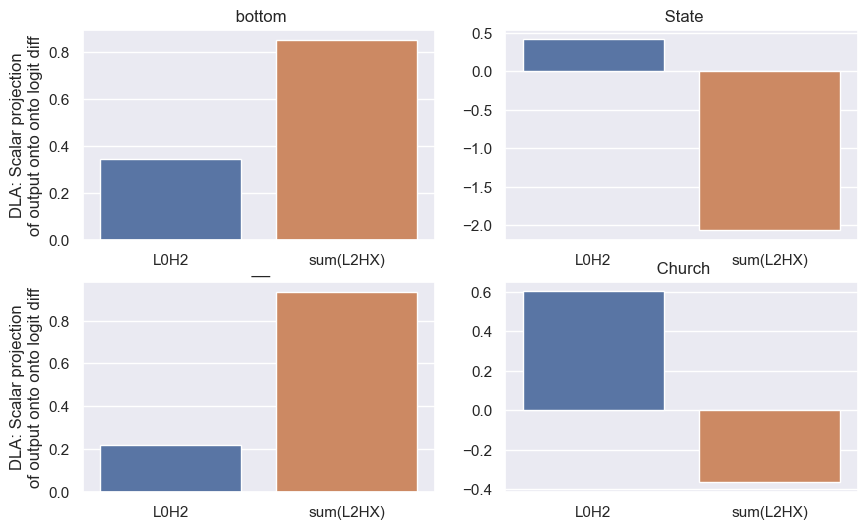

In [13]:
fig, ax = plt.subplots(2,2, figsize=(10,6))

for i in range(len(examples)):
    head_names = ["L0H2", "sum(L2HX)"]
    dla_all = get_results(model, examples[i])
    L0H2_dla, L2HX_dla, v_comp_dla = [dla.item() for dla in dla_all]

    # Select DLA values to plot
    dla_plot = [L0H2_dla, L2HX_dla]

    row = i // 2
    col = i % 2
    sns.barplot(x=head_names, y=dla_plot, ax=ax[row][col])
    ax[row][col].set_title(examples[i]["correct"])
    if col == 0:
        ax[row][col].set_ylabel("DLA: Scalar projection\nof output onto onto logit diff")

## DLA L0H2 vs DLA sum(V-Composition L0H2 -> L2HX)

You could get a little more nuanced here, by actually taking the vectors written by L0H2, multiplying them with the W_OV matrix of later heads in layer 2, and scaling them (using cached scale factors). This actually tells you how much the layer-2 heads erase the output of earlier heads specifically from V-composition with them.

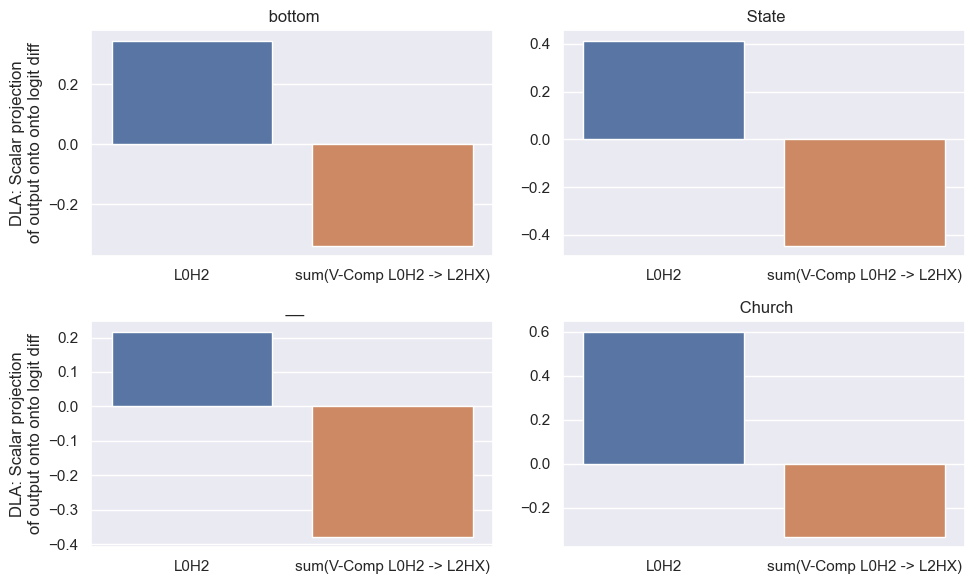

In [14]:
fig, ax = plt.subplots(2,2, figsize=(10,6))

for i in range(len(examples)):
    head_names = ["L0H2", "sum(V-Comp L0H2 -> L2HX)"]
    dla_all = get_results(model, examples[i])
    L0H2_dla, L2Hx_dla, v_comp_dla = [dla.item() for dla in dla_all]

    # Select DLA values to plot
    dla_plot = [L0H2_dla, v_comp_dla]

    row = i // 2
    col = i % 2
    sns.barplot(x=head_names, y=dla_plot, ax=ax[row][col])
    ax[row][col].set_title(examples[i]["correct"])
    if col == 0:
        ax[row][col].set_ylabel("DLA: Scalar projection\nof output onto onto logit diff")

plt.tight_layout()